In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
import keras
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Preparing data

In [60]:
df = pd.read_csv('../data/Airlines.csv')
df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


In [61]:
df.isnull().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [62]:
df.dtypes

id              int64
Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object

In [63]:
df.drop(columns=['id'], inplace=True)

In [64]:
cols = df.columns
for i in range(0,len(cols)):
    print(df[cols[i]].value_counts(),'\n')
    print('********************************************\n')

Airline
WN    94097
DL    60940
OO    50254
AA    45656
MQ    36605
US    34500
XE    31126
EV    27983
UA    27619
CO    21118
FL    20827
9E    20686
B6    18112
YV    13725
OH    12630
AS    11471
F9     6456
HA     5578
Name: count, dtype: int64 

********************************************

Flight
16      420
5       407
9       401
8       396
62      364
       ... 
7814      1
3573      1
4385      1
3292      1
6969      1
Name: count, Length: 6585, dtype: int64 

********************************************

AirportFrom
ATL    34449
ORD    24822
DFW    22154
DEN    19843
LAX    16657
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: count, Length: 293, dtype: int64 

********************************************

AirportTo
ATL    34440
ORD    24871
DFW    22153
DEN    19848
LAX    16656
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: count, Length: 293, dtype: int64 

***************************************

In [65]:
le = preprocessing.LabelEncoder()

df['Airline'] = le.fit_transform(df['Airline'])
df['AirportFrom'] = le.fit_transform(df['AirportFrom'])
df['AirportTo'] = le.fit_transform(df['AirportTo'])

In [66]:
df

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,4,269,253,135,3,15,205,1
1,14,1558,217,60,3,15,222,1
2,1,2400,154,80,3,20,165,1
3,1,2466,253,80,3,20,195,1
4,2,108,14,252,3,30,202,0
...,...,...,...,...,...,...,...,...
539378,4,178,203,264,5,1439,326,0
539379,8,398,252,16,5,1439,305,0
539380,8,609,253,184,5,1439,255,0
539381,13,78,128,253,5,1439,313,1


# Visualize some features of data

In [67]:
df['Length_by_hours'] = df['Length'] / 60
df['Time_by_hour'] = df['Time'] / 60

In [68]:
df.drop(columns=['Length', 'Time'], inplace=True)

# Feature extraction

In [69]:
#0 --> Morning | 1 --> Afternoon | 2 --> Evening | 3 --> Night
departure_period = []
for i in range(0,len(df)):
    if ((df['Time_by_hour'][i] >= 5) & (df['Time_by_hour'][i] < 12)):
        departure_period.append(0)
    elif ((df['Time_by_hour'][i] >= 12) & (df['Time_by_hour'][i] < 17)):
        departure_period.append(1)
    elif ((df['Time_by_hour'][i] >= 17) & (df['Time_by_hour'][i] < 21)):
        departure_period.append(2)
    else:
        departure_period.append(3)

df['Departure_period'] = departure_period

In [70]:
df['Departure_period'].value_counts()

Departure_period
0    223289
1    170239
2    120044
3     25811
Name: count, dtype: int64

In [71]:
# 0 --> not holiday | 1 --> holiday
holiday = []
for i in range(0,len(df)):
    if ((df['DayOfWeek'][i] == 6) | (df['DayOfWeek'][i] == 7)):
        holiday.append(1)
    else:
        holiday.append(0)

df['Holiday'] = holiday

In [72]:
df['Holiday'].value_counts()

Holiday
0    410548
1    128835
Name: count, dtype: int64

In [73]:
arrival_time = []
for i in range(0,len(df)):
    if ((df['Time_by_hour'][i] + df['Length_by_hours'][i]) >=24):
        arrival_time.append((df['Time_by_hour'][i] + df['Length_by_hours'][i])-24)
    else:
        arrival_time.append(df['Time_by_hour'][i] + df['Length_by_hours'][i])

df['Arrival_Time'] = arrival_time

In [74]:
arrival_period = []
for i in range(0,len(df)):
    if ((df['Arrival_Time'][i] >= 5) & (df['Arrival_Time'][i] < 12)):
        arrival_period.append(0)
    elif ((df['Arrival_Time'][i] >= 12) & (df['Arrival_Time'][i] < 17)):
        arrival_period.append(1)
    elif ((df['Arrival_Time'][i] >= 17) & (df['Arrival_Time'][i] < 21)):
        arrival_period.append(2)
    else:
        arrival_period.append(3)

df['Arrival_period'] = arrival_period

In [75]:
df
df['Route'] = df['AirportFrom'].astype(str) + "_" + df['AirportTo'].astype(str)
df['Route_Frequency'] = df['Route'].map(df['Route'].value_counts())
df['Route_Frequency'] = df['Route_Frequency'].astype(int)
df['Route_Frequency'].value_counts()



Route_Frequency
62    12586
31    12586
87     6264
88     5720
61     4636
      ...  
11       33
7        21
19       19
1        17
3         9
Name: count, Length: 493, dtype: int64

In [76]:

df['Route'] = df['AirportFrom'].astype(str) + "_" + df['AirportTo'].astype(str)
df['Route_Frequency'] = df['Route'].map(df['Route'].value_counts())
airline_delay_rate = df.groupby('Airline')['Delay'].mean()
df['Airline_DelayRate'] = df['Airline'].map(airline_delay_rate)

df['AirportFrom_Frequency'] = df['AirportFrom'].map(df['AirportFrom'].value_counts())
df['AirportTo_Frequency'] = df['AirportTo'].map(df['AirportTo'].value_counts())

df['Reverse_Route'] = df['AirportTo'].astype(str) + "_" + df['AirportFrom'].astype(str)
df['Is_RoundTrip'] = df['Reverse_Route'].isin(df['Route']).astype(int)

df['Quarter'] = ((df['DayOfWeek'] - 1) // 2) + 1

df['Is_Peak_Hour'] = df['Time_by_hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 19 else 0)

In [ ]:
df['Route'] = df['AirportFrom'].astype(str) + "_" + df['AirportTo'].astype(str)

airport_from_delay = df.groupby('AirportFrom')['Delay'].mean()
df['AirportFrom_DelayRate'] = df['AirportFrom'].map(airport_from_delay)

airport_to_delay = df.groupby('AirportTo')['Delay'].mean()
df['AirportTo_DelayRate'] = df['AirportTo'].map(airport_to_delay)

route_delay_avg = df.groupby('Route')['Delay'].mean()
route_delay_std = df.groupby('Route')['Delay'].std().fillna(0)
df['Route_AvgDelay'] = df['Route'].map(route_delay_avg)
df['Route_StdDelay'] = df['Route'].map(route_delay_std)

df['IsWeekend'] = df['Quarter'].apply(lambda x: 1 if x in [3, 4] else 0)

df['Season'] = df['Quarter']
df

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Delay,Length_by_hours,Time_by_hour,Departure_period,Holiday,...,Reverse_Route,Is_RoundTrip,Quarter,Is_Peak_Hour,AirportFrom_DelayRate,AirportTo_DelayRate,Route_AvgDelay,Route_StdDelay,IsWeekend,Season
0,4,269,253,135,3,1,3.416667,0.250000,3,0,...,135_253,1,2,0,0.532920,0.402933,0.800866,0.400216,0,2
1,14,1558,217,60,3,1,3.700000,0.250000,3,0,...,60_217,1,2,0,0.439931,0.319799,0.418972,0.494369,0,2
2,1,2400,154,80,3,1,2.750000,0.333333,3,0,...,80_154,1,2,0,0.496488,0.318151,0.347426,0.476591,0,2
3,1,2466,253,80,3,1,3.250000,0.333333,3,0,...,80_253,1,2,0,0.532920,0.318151,0.525836,0.500093,0,2
4,2,108,14,252,3,0,3.366667,0.500000,3,0,...,252_14,1,2,0,0.317521,0.486322,0.344519,0.475744,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,4,178,203,264,5,0,5.433333,23.983333,3,0,...,264_203,1,3,0,0.253950,0.513720,0.375000,0.500000,1,3
539379,8,398,252,16,5,0,5.083333,23.983333,3,0,...,16_252,1,3,0,0.419134,0.383769,0.515306,0.501045,1,3
539380,8,609,253,184,5,0,4.250000,23.983333,3,0,...,184_253,1,3,0,0.532920,0.416462,0.565217,0.501206,1,3
539381,13,78,128,253,5,1,5.216667,23.983333,3,0,...,253_128,1,3,0,0.319488,0.528918,0.313084,0.464836,1,3


# Correlation among features

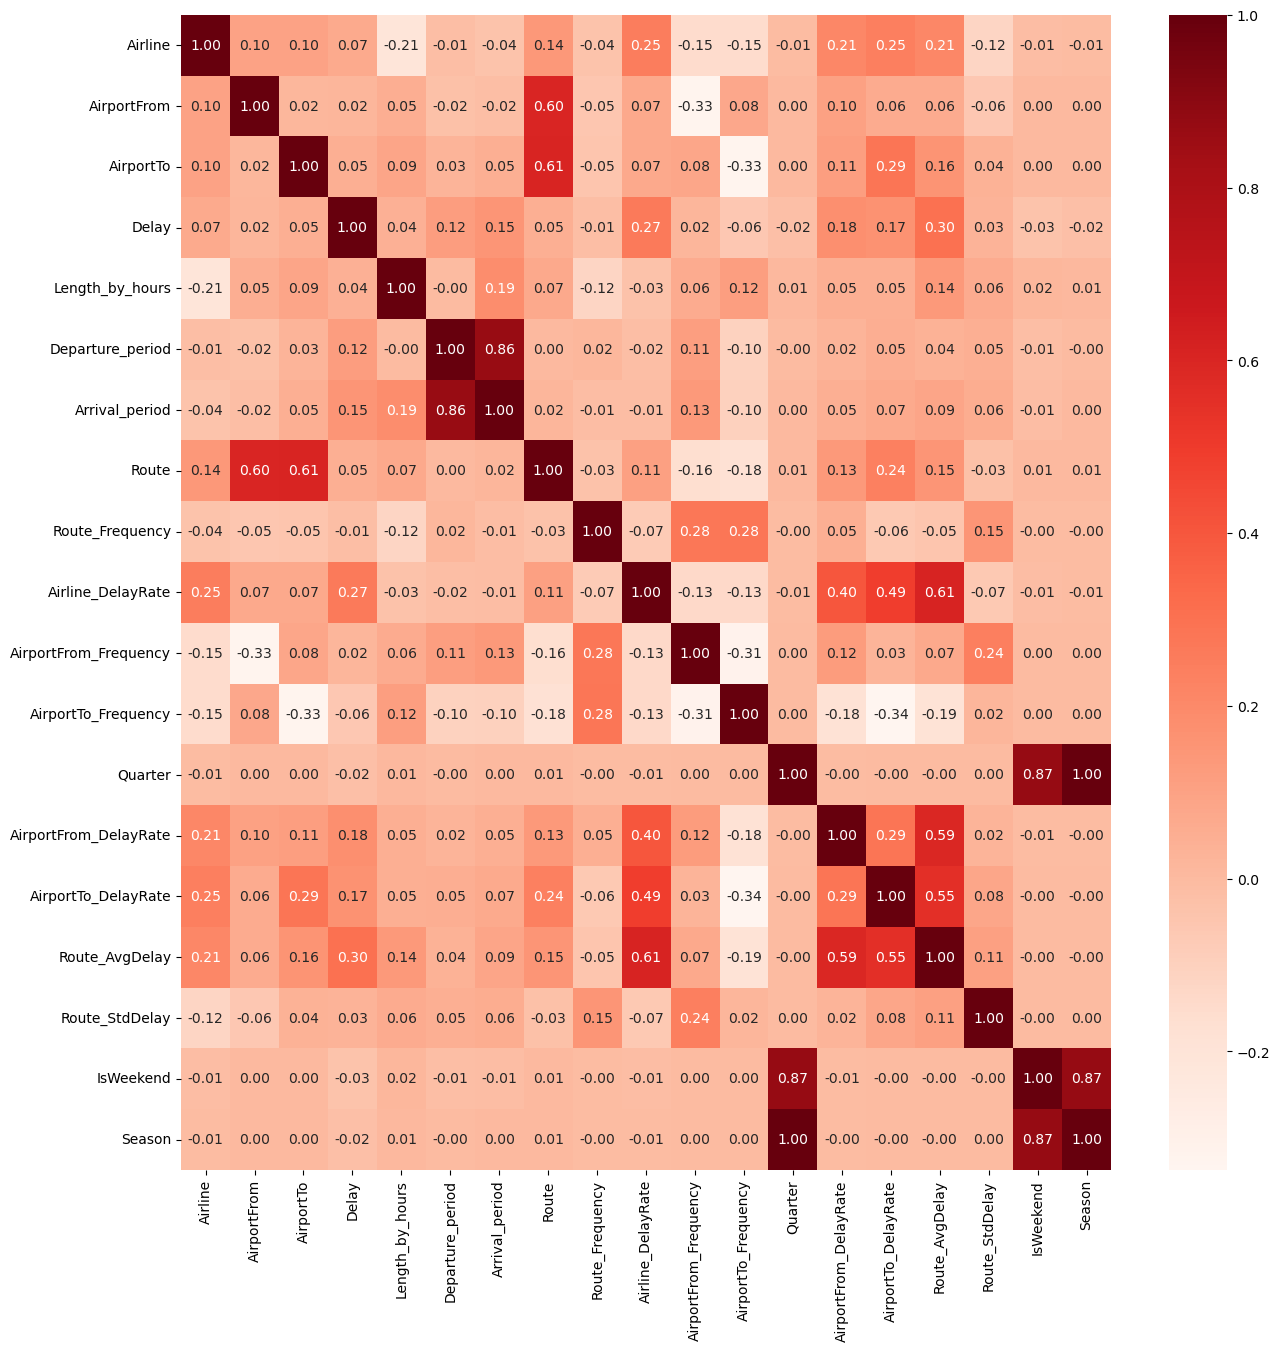

In [ ]:
plt.figure(figsize=(15,15))
df1 = df.drop(columns=[
    'Flight',               
    'Holiday',              
    'Is_RoundTrip',         
    'Is_Peak_Hour',         
    'Time_by_hour',         
    'Arrival_Time',         
    'Reverse_Route',        
    'DayOfWeek'       
      ]
    ) 
cor = df1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

In [91]:
X = df1.drop(columns='Delay')
y = df1['Delay']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True)

# Some ML Models

In [93]:
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='entropy',max_depth=16,random_state=40)
DecisionTreeClassifierModel.fit(X_train, y_train)

print('DecisionTreeClassifierModel Train Score is : ' , DecisionTreeClassifierModel.score(X_train, y_train))
print('DecisionTreeClassifierModel Test Score is : ' , DecisionTreeClassifierModel.score(X_test, y_test))

DecisionTreeClassifierModel Train Score is :  0.6948257677507601
DecisionTreeClassifierModel Test Score is :  0.6527002725300802


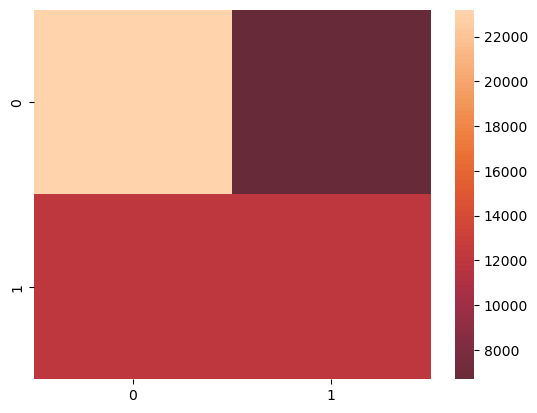

Confusion Matrix is
 [[23201  6689]
 [12044 12005]]


In [94]:
y_pred_DT = DecisionTreeClassifierModel.predict(X_test)

CM_DT = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(CM_DT, center=True)
plt.show()

print('Confusion Matrix is\n', CM_DT)

In [84]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'entropy', max_depth=18, n_estimators=400, random_state=44)
RandomForestClassifierModel.fit(X_train, y_train)

print('RandomForestClassifierModel Train Score is : ' , RandomForestClassifierModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RandomForestClassifierModel.score(X_test, y_test))

RandomForestClassifierModel Train Score is :  0.7557411359497697
RandomForestClassifierModel Test Score is :  0.6643615936520885


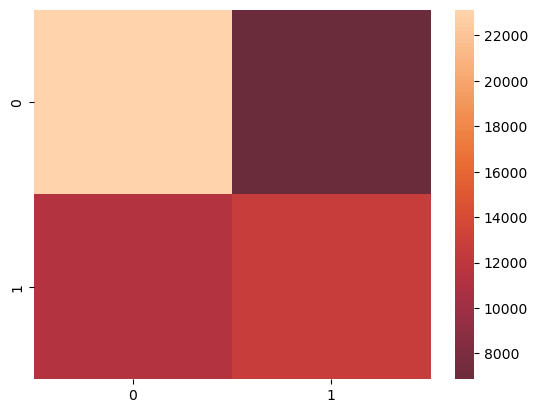

Confusion Matrix is
 [[23137  6858]
 [11246 12698]]


In [85]:
y_pred_RF = RandomForestClassifierModel.predict(X_test)
CM_RF = confusion_matrix(y_test, y_pred_RF)

sns.heatmap(CM_RF, center=True)
plt.show()

print('Confusion Matrix is\n', CM_RF)

In [86]:
GBCModel = GradientBoostingClassifier(n_estimators=300, max_depth=8, learning_rate=0.25, random_state=44)
GBCModel.fit(X_train, y_train)
print('GBCModel Train Score is : ' , GBCModel.score(X_train, y_train))
print('GBCModel Test Score is : ' , GBCModel.score(X_test, y_test))

GBCModel Train Score is :  0.7381469335288932
GBCModel Test Score is :  0.66881106435047


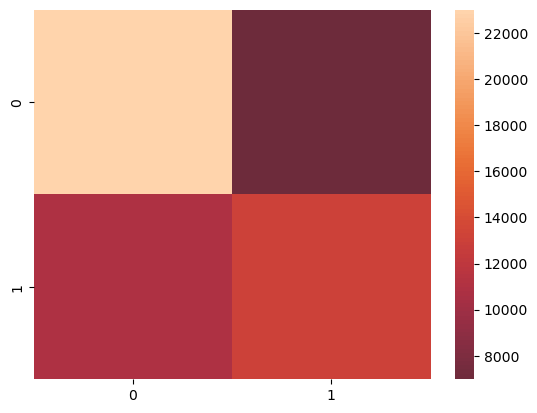

Confusion Matrix is
 [[23017  6978]
 [10886 13058]]


In [87]:
y_pred_GB = GBCModel.predict(X_test)
CM_GB = confusion_matrix(y_test, y_pred_GB)

sns.heatmap(CM_GB, center=True)
plt.show()

print('Confusion Matrix is\n', CM_GB)

In [88]:
VotingClassifierModel = VotingClassifier(estimators=[('GBCModel',GBCModel),
                                                     ('RFCModel',RandomForestClassifierModel),
                                                     ('TDCModel',DecisionTreeClassifierModel)],
                                         voting='hard')
VotingClassifierModel.fit(X_train, y_train)
print('VotingClassifierModel Train Score is : ' , VotingClassifierModel.score(X_train, y_train))
print('VotingClassifierModel Test Score is : ' , VotingClassifierModel.score(X_test, y_test))

VotingClassifierModel Train Score is :  0.7434801954499386
VotingClassifierModel Test Score is :  0.6680694859007398


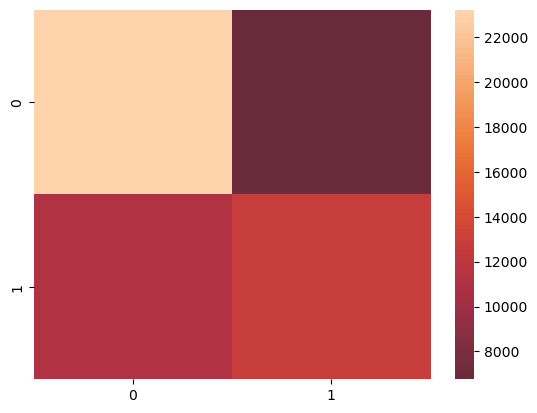

Confusion Matrix is
 [[23241  6754]
 [11150 12794]]


In [89]:
y_pred_V = VotingClassifierModel.predict(X_test)
CM_V = confusion_matrix(y_test, y_pred_V)
sns.heatmap(CM_V, center=True)
plt.show()
print('Confusion Matrix is\n', CM_V)

In [90]:
# Drop label column and keep only numeric features
X = df1.drop(columns=['Delay'])
X = X.select_dtypes(include=[int, float, bool])  # removes object columns safely

y = df['Delay']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

print("XGBoost Train Score:", model.score(X_train, y_train))
print("XGBoost Test Score:", model.score(X_test, y_test))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:43:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Train Score: 0.6723452281080681
XGBoost Test Score: 0.6673711727244918
